시공간 정보로부터 사고위험도(ECLO)를 예측하는 AI 알고리즘

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.9 MB/s eta 0:00:00


In [2]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

train_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/train.csv')
train_org = train_org.drop(columns=train_org.iloc[:,8:18])
test_org = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/test.csv')
train_org.info()
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   시군구     39609 non-null  object
 5   도로형태    39609 non-null  object
 6   노면상태    39609 non-null  object
 7   사고유형    39609 non-null  object
 8   사망자수    39609 non-null  int64 
 9   중상자수    39609 non-null  int64 
 10  경상자수    39609 non-null  int64 
 11  부상자수    39609 non-null  int64 
 12  ECLO    39609 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 3.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    

In [3]:
#텍스트 나누기

train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사망자수', '중상자수',\n       '경상자수', '부상자수', 'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사망자수', '중상자수', '경상자수',\n       '부상자수', 'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

트레인 테스트에 cctv정보추가

In [4]:
child_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_어린이_보호_구역_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_df[['도시', '구', '동','번지']] = child_df['소재지지번주소'].str.extract(location_pattern)
child_df = child_df.drop(columns=['소재지지번주소'])

child_cctv_df = {'동':[],
                 '어린이CCTV설치대수':[]}
child_cctv_df = pd.DataFrame(child_cctv_df)

#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in child_df['동'].unique() :
  temp_list.append(len(child_df[child_df['동']==i].loc[:,'CCTV설치대수']))

child_cctv_df['동'] = child_df['동'].unique()
child_cctv_df['어린이CCTV설치대수'] = temp_list
child_cctv_df = child_cctv_df.dropna(axis=0) #nan값이 하나 있어서

#train, test 어린이cctv여부 추가

train_df = pd.merge(train_df, child_cctv_df, on='동', how='left')
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, child_cctv_df, on='동', how='left')
test_df = test_df.fillna(0)

cctv_df = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/external_open/대구_CCTV_정보.csv', encoding='cp949')
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동','번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소'])

cctv_list = {'동':[],
             'CCTV개수':[]}
cctv_list = pd.DataFrame(cctv_list)
#동마다 CCTV 갯수 넣을꺼
temp_list = []
for i in cctv_df['동'].unique() :
  temp_list.append(len(cctv_df[(cctv_df['동']==i)&((cctv_df['단속구분']==2)|(cctv_df['단속구분']==1)|(cctv_df['단속구분']==99))]))

cctv_list['동'] = cctv_df['동'].unique()
cctv_list['CCTV개수'] = temp_list
cctv_list = cctv_list.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, cctv_list, on='동', how='left')
train_df = train_df.fillna(0)

test_df = pd.merge(test_df, cctv_list, on='동', how='left')
test_df = test_df.fillna(0)

#동마다 CCTV 제한속도 평균
speed_df = {'동':[],
             '평균속도':[]}
speed_df = pd.DataFrame(speed_df)
speed_list = []
for i in cctv_df['동'].unique() :
  temp_list = []
  count_list = []
  temp = 0
  sum_list = []
  for j in [30,50,60,70,80,100] :
    temp_list.append(len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)])*j)
    temp += (len(cctv_df[(cctv_df['제한속도']==j)&(cctv_df['동']== i)]))
    #print(temp_list)
    #print(temp)

  sum_list = sum(temp_list)
  if temp != 0 :
    speed_list.append(sum_list/temp)
  else:
    speed_list.append(38)
  #print(speed_list)
#len(speed_list)

speed_df['동'] = cctv_df['동'].unique()
speed_df['평균속도'] = speed_list
speed_df = speed_df.dropna(axis=0) #nan값이 하나 있어서

#train, test cctv_list 추가

train_df = pd.merge(train_df, speed_df, on='동', how='left')
print(train_df.shape)
train_df = train_df.fillna(0)
print(train_df.isnull().sum())

test_df = pd.merge(test_df, speed_df, on='동', how='left')
print(test_df.shape)
test_df = test_df.fillna(0)
print(test_df.isnull().sum())


(39609, 22)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
사망자수           0
중상자수           0
경상자수           0
부상자수           0
ECLO           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64
(10963, 17)
ID             0
요일             0
기상상태           0
노면상태           0
사고유형           0
연              0
월              0
일              0
시간             0
도시             0
구              0
동              0
도로형태1          0
도로형태2          0
어린이CCTV설치대수    0
CCTV개수         0
평균속도           0
dtype: int64


기상상태 비이고 노면상태 기타 경우 젖음/습기로 변경<br>
미분류 도로 가장 많은 도로형태로 수정

In [5]:
train_df.loc[4185,'노면상태'] = '젖음/습기'
train_df.loc[5135,'노면상태'] = '젖음/습기'
train_df.loc[6892,'노면상태'] = '젖음/습기'
train_df.loc[33750,'노면상태'] = '젖음/습기'
train_df.loc[35213,'노면상태'] = '젖음/습기'
train_df.loc[36407,'노면상태'] = '젖음/습기'

train_df.loc[983,'도로형태1'] = '단일로'
train_df.loc[1084,'도로형태1'] = '단일로'
train_df.loc[12779,'도로형태1'] = '교차로'
train_df.loc[15742,'도로형태1'] = '단일로'
train_df.loc[16924,'도로형태1'] = '단일로'
train_df.loc[21393,'도로형태1'] = '단일로'
train_df.loc[26090,'도로형태1'] = '교차로'

train_df.loc[983,'도로형태2'] = '기타'
train_df.loc[1084,'도로형태2'] = '기타'
train_df.loc[12779,'도로형태2'] = '기타'
train_df.loc[15742,'도로형태2'] = '기타'
train_df.loc[16924,'도로형태2'] = '기타'
train_df.loc[21393,'도로형태2'] = '기타'
train_df.loc[26090,'도로형태2'] = '기타'

In [6]:
from sklearn.preprocessing import OneHotEncoder

# 여러 조건에 따라 값을 설정하는 함수 정의

def assign_category(value):
    if value in [1,2,3,4]:
        return '새벽'
    elif value in [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,6,5]:
        return '그외'
    else:
        return 'Unknown'

def weekday_category(value):
    if value in ['화요일','수요일','목요일','금요일','월요일']:
        return '주간'
    elif value in ['토요일','일요일']:
        return '주말'
    else:
        return 'Unknown'

# 'Value' 열에 대해 새로운 열 생성
train_df['통합시간'] = train_df['시간'].apply(assign_category)
train_df['통합요일'] = train_df['요일'].apply(weekday_category)
test_df['통합시간'] = test_df['시간'].apply(assign_category)
test_df['통합요일'] = test_df['요일'].apply(weekday_category)

encoder1 = OneHotEncoder()
encoder2 = OneHotEncoder()

train_time = encoder1.fit_transform(train_df[['통합시간']])
test_time = encoder1.transform(test_df[['통합시간']])

train_day = encoder2.fit_transform(train_df[['통합요일']])
test_day = encoder2.transform(test_df[['통합요일']])

train_time, train_day, test_time, test_day = [array.toarray() for array in (train_time, train_day, test_time, test_day)]

train_time, train_day, test_time, test_day = [pd.DataFrame(array) for array in (train_time, train_day, test_time, test_day)]

train_time.columns = encoder1.get_feature_names_out()
train_day.columns = encoder2.get_feature_names_out()

test_time.columns = encoder1.get_feature_names_out()
test_day.columns = encoder2.get_feature_names_out()

train_df = pd.concat([train_df,train_time],axis=1)
train_df = pd.concat([train_df,train_day],axis=1)

test_df = pd.concat([test_df,test_time],axis=1)
test_df = pd.concat([test_df,test_day],axis=1)

train_df = train_df.drop(columns=['통합시간','통합요일'])
test_df = test_df.drop(columns=['통합시간','통합요일'])

피처, 타겟 분리 라벨인코딩

In [7]:
from sklearn.preprocessing import MinMaxScaler

X_num = train_df[['어린이CCTV설치대수','CCTV개수','평균속도']]
scaler = MinMaxScaler()
transform_X_num = scaler.fit_transform(X_num)
transform_X_num = pd.DataFrame(transform_X_num)
transform_test_num = scaler.transform(test_df[['어린이CCTV설치대수','CCTV개수','평균속도']])
transform_test_num = pd.DataFrame(transform_test_num)
X_scaled = pd.concat([train_df, transform_X_num], axis=1)
test_scaled = pd.concat([test_df, transform_test_num], axis=1)
X_scaled.drop(columns=['어린이CCTV설치대수','CCTV개수','평균속도'], inplace=True)
test_scaled.drop(columns=['어린이CCTV설치대수','CCTV개수','평균속도'], inplace=True)

from sklearn.preprocessing import LabelEncoder

#FEATURE = ['기상상태','노면상태','사고유형','구','동','도로형태1','도로형태2','요일','도시']
FEATURE = ['기상상태','노면상태','구','동','도로형태1','도로형태2','사고유형','요일']
for i in FEATURE:
    le = LabelEncoder()
    X_scaled[i]= le.fit_transform(X_scaled[i])
    test_scaled[i]= le.transform(test_scaled[i])

test_scaled

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,...,동,도로형태1,도로형태2,통합시간_그외,통합시간_새벽,통합요일_주간,통합요일_주말,0,1,2
0,ACCIDENT_39609,5,2,0,0,2022,1,1,1,대구광역시,...,99,0,3,0.0,1.0,0.0,1.0,0.083333,0.076923,0.525000
1,ACCIDENT_39610,5,2,0,0,2022,1,1,1,대구광역시,...,168,2,5,0.0,1.0,0.0,1.0,0.166667,0.134615,0.471429
2,ACCIDENT_39611,5,2,0,1,2022,1,1,4,대구광역시,...,117,0,3,0.0,1.0,0.0,1.0,0.016667,0.019231,0.380000
3,ACCIDENT_39612,5,2,0,1,2022,1,1,4,대구광역시,...,126,2,5,0.0,1.0,0.0,1.0,0.116667,0.211538,0.427273
4,ACCIDENT_39613,5,2,0,1,2022,1,1,6,대구광역시,...,4,0,3,1.0,0.0,0.0,1.0,0.000000,0.076923,0.525000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,5,2,0,1,2022,12,31,18,대구광역시,...,38,2,9,1.0,0.0,0.0,1.0,0.433333,0.519231,0.486364
10959,ACCIDENT_50568,5,2,0,1,2022,12,31,18,대구광역시,...,123,2,5,1.0,0.0,0.0,1.0,0.083333,0.076923,0.525000
10960,ACCIDENT_50569,5,2,0,1,2022,12,31,20,대구광역시,...,134,2,5,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
10961,ACCIDENT_50570,5,2,0,1,2022,12,31,20,대구광역시,...,77,0,2,1.0,0.0,0.0,1.0,0.116667,0.134615,0.442857


In [8]:
#X = train_df.drop(columns=['ECLO','부상자수','경상자수','중상자수','사망자수','피해운전자 상해정도','피해운전자 연령','피해운전자 차종','가해운전자 상해정도',
                           #'가해운전자 연령','가해운전자 성별','가해운전자 차종','법규위반','사고유형 - 세부분류','피해운전자 성별','도시'])
X = X_scaled.drop(columns=['ID','도시','ECLO','사망자수','중상자수','경상자수','부상자수'])
y = X_scaled['ECLO']
test_scaled = test_scaled.drop(columns=['ID','도시'])
X

,요일,기상상태,노면상태,사고유형,연,월,일,시간,구,동,도로형태1,도로형태2,통합시간_그외,통합시간_새벽,통합요일_주간,통합요일_주말,0,1,2
0,6,2,0,0,2019,1,1,0,7,40,2,5,1.0,0.0,1.0,0.0,0.033333,0.019231,0.380000
1,6,5,0,0,2019,1,1,0,1,4,2,5,1.0,0.0,1.0,0.0,0.000000,0.076923,0.525000
2,6,2,0,0,2019,1,1,1,6,66,2,5,0.0,1.0,1.0,0.0,0.083333,0.076923,0.550000
3,6,2,0,1,2019,1,1,2,4,79,2,5,0.0,1.0,1.0,0.0,0.183333,0.192308,0.375000
4,6,2,0,1,2019,1,1,4,3,129,2,5,0.0,1.0,1.0,0.0,0.000000,0.230769,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,0,2,0,1,2021,12,31,19,6,118,0,3,1.0,0.0,1.0,0.0,0.016667,0.019231,0.380000
39605,0,2,0,1,2021,12,31,19,1,103,2,5,1.0,0.0,1.0,0.0,0.000000,0.346154,0.450000
39606,0,2,0,1,2021,12,31,21,1,144,0,3,1.0,0.0,1.0,0.0,0.000000,0.173077,0.411111
39607,0,2,0,1,2021,12,31,22,1,158,1,5,1.0,0.0,1.0,0.0,0.000000,0.019231,0.600000


In [9]:
result = X_scaled.groupby(['동'])['ECLO'].mean()
filtered_result = result[result > 6.8]

In [10]:
eclo_68 = X_scaled[X_scaled['동'].isin(filtered_result.index)]
eclo_68_test = test_scaled[test_scaled['동'].isin(filtered_result.index)]
X_68 = eclo_68.drop(columns=['ID','도시','ECLO','사망자수','중상자수','경상자수','부상자수'])
y_68 = eclo_68['ECLO']

In [11]:
under68_eclo = X_scaled[~X_scaled['동'].isin(filtered_result.index)]
under68_eclo_test = test_scaled[~test_scaled['동'].isin(filtered_result.index)]
under_68 = under68_eclo.drop(columns=['ID','도시','ECLO','사망자수','중상자수','경상자수','부상자수'])
undery_68 = under68_eclo['ECLO']

모델 훈련 및 예측

In [12]:
params = {
    'lambda': 0.011825773074770396,
    'alpha': 0.5044643996727611,
    'colsample_bytree': 0.8531532574509729,
    'subsample': 0.8021843456119657,
    'learning_rate': 0.012079406386966347,
    'n_estimators': 772,
    'max_depth': 5,
    'min_child_weight': 2,
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle',
}

model = xgb.XGBRegressor(**params)

# 모델 훈련
model.fit(X_68, y_68)

# 테스트 데이터로 예측
y_pred = model.predict(eclo_68_test)



In [13]:
params = {
    'lambda': 0.011825773074770396,
    'alpha': 0.5044643996727611,
    'colsample_bytree': 0.8531532574509729,
    'subsample': 0.8021843456119657,
    'learning_rate': 0.012079406386966347,
    'n_estimators': 772,
    'max_depth': 5,
    'min_child_weight': 2,
    'objective': 'reg:squaredlogerror',
    'eval_metric': 'rmsle',
}

model = xgb.XGBRegressor(**params)

# 모델 훈련
model.fit(under_68, undery_68)

# 테스트 데이터로 예측
y_pred_under = model.predict(under68_eclo_test)



In [14]:
eclo_68_test['ECLO'] = y_pred
eclo_68_test
under68_eclo_test['ECLO'] = y_pred_under
under68_eclo_test
pred_sub = pd.concat([eclo_68_test, under68_eclo_test])
pred_sub
pred_sub = pred_sub.sort_index()

In [15]:
pred_sub = pred_sub['ECLO'].values
pred_sub

array([3.945288 , 3.5268366, 5.07619  , ..., 4.3573523, 4.2278166,
       4.308414 ], dtype=float32)

In [16]:

y_pred_under = pd.DataFrame(y_pred_under)
sample_submission = pd.read_csv('/content/drive/MyDrive/colab/daegu_traffic/sample_submission.csv')
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = pred_sub
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,3.945288
1,ACCIDENT_39610,3.526837
2,ACCIDENT_39611,5.076190
3,ACCIDENT_39612,4.358796
4,ACCIDENT_39613,4.741326
...,...,...
10958,ACCIDENT_50567,4.291551
10959,ACCIDENT_50568,4.172322
10960,ACCIDENT_50569,4.357352
10961,ACCIDENT_50570,4.227817


<Axes: >

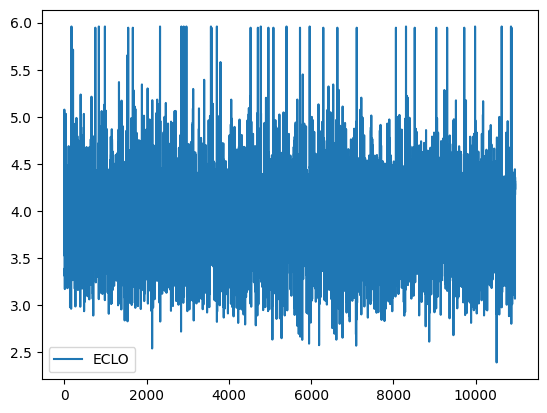

In [17]:
baseline_submission.plot()

In [ ]:
baseline_submission.to_csv('xgboost60.csv', index=False)